# Solution development.

## Scenario one: we can measure rental date for 100% of the trips.

Let's start by loading the simulated data. 
As stated in the challenge statement, we can only use the rental date of each RPC. We don't know the return date or the duration of the trip.    

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime , timedelta

In [2]:

trip_mean_days = 100
df0 = pd.read_csv("data/rpc_rents.csv")

## keep only rpc_id and rental_date columns
df = df0[["rpc_id","rental_date"]]
df.head()

,rpc_id,rental_date
0,890,2021-09-26
1,3286,2020-08-20
2,378,2021-01-24
3,1512,2020-05-15
4,4867,2020-04-01


As a first step, we will explore the data. 

In [3]:
df.shape

(74586, 2)

In [4]:
df.rpc_id.nunique()

5000

In [5]:
df.rental_date.min()

'2020-01-01'

We have a dataset with 74586 rentals (or trips) from 5000 different assets, and the first rental was on January 1, 2020.
Given that today is November 16, 2024. We have 4 years and almost 11 months of data.  

### Shrinking rate estimation

We know that the real mean duration of a trip is 100 days. The first question that comes to my mind is: after how many days can we consider an RPC to be lost? 
To answer this question, let's see what is the time difference between two rentals. Since we don't know the return date and we don't know how long an asset is waiting in the pool we can approximate the duration of each trip by looking at that number. 

In [6]:
df["rental_date"] = pd.to_datetime(df["rental_date"])
df = df.sort_values(by=['rpc_id', 'rental_date'])
df["diff_days"] = df.groupby("rpc_id")["rental_date"].diff().dt.days
df["diff_days"] = df.groupby("rpc_id")["diff_days"].shift(-1)

print(df)

       rpc_id rental_date  diff_days
36388       0  2020-01-11       81.0
45901       0  2020-04-01      144.0
66715       0  2020-08-23       69.0
10513       0  2020-10-31       86.0
57968       0  2021-01-25      138.0
...       ...         ...        ...
44003    4999  2023-10-25      143.0
11136    4999  2024-03-16       61.0
18836    4999  2024-05-16      126.0
31534    4999  2024-09-19       53.0
11000    4999  2024-11-11        NaN

[74586 rows x 3 columns]


/tmp/ipykernel_201736/72152160.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rental_date"] = pd.to_datetime(df["rental_date"])


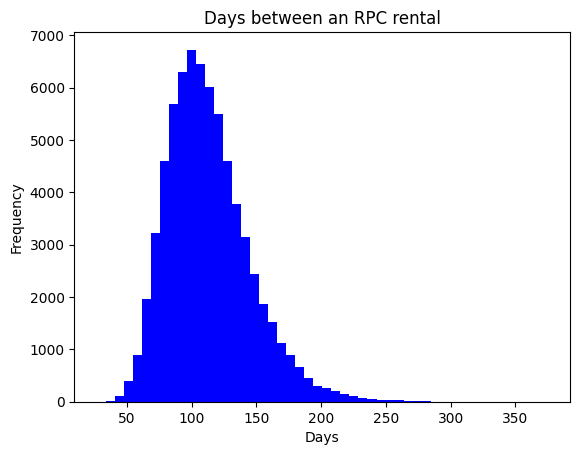

In [7]:
plt.hist(df['diff_days'], bins = 50, color = 'blue')

plt.title("Days between an RPC rental")
plt.xlabel("Days")
plt.ylabel("Frequency")

plt.show()

In [8]:
print("Maximum number of days between rentals:", df.diff_days.max())
print("Average number of days between rentals:", df.diff_days.mean())
average_days_between_rentals = df.diff_days.mean()

Maximum number of days between rentals: 375.0
Average number of days between rentals: 113.0592647946426


As we know, the average duration of a trip is 100 days. From the above calculation we can assume that an asset stays in the SC 13 days on average. 
We could subtract 13 days from the difference to have a more accurate estimate of the trip duration, but this is not relevant information for calculating the probability of loss. 

Let's look at other statistical information. One possible method to answer the question “When can we consider an asset lost?” is to calculate the IQR. Since we are not working with a normal distribution, we need to normalize our data to calculate that limit. 

In [9]:
df["log_diff_days"] = np.log(df.diff_days)
q1 = df.log_diff_days.quantile(0.25)
q3 = df.log_diff_days.quantile(0.75)
iqr = q3-q1
log_upper_limit = q3 + 1.5*iqr
upper_limit = np.exp(log_upper_limit)
upper_limit = int(round(upper_limit,0))
print(f"Rentals that take longer than {upper_limit} until the next rental are outliers.")



Rentals that take longer than 230 until the next rental are outliers.


Therefore, we will assume that if an asset is not rented again in 230 days (upper_limit_value) we can consider it lost.
Lets identify in our dataset the lost assets.  
We will consider an asset that was last rented more than 230 days ago as lost. 
To start with, we will discard those rentals that started less than 230 days ago, since those assets can still be returned. We will not consider them for the analysis.

In [10]:
df1 = df[df["rental_date"] < (datetime.today() - timedelta(days=int(upper_limit)))]
print(df1)

       rpc_id rental_date  diff_days  log_diff_days
36388       0  2020-01-11       81.0       4.394449
45901       0  2020-04-01      144.0       4.969813
66715       0  2020-08-23       69.0       4.234107
10513       0  2020-10-31       86.0       4.454347
57968       0  2021-01-25      138.0       4.927254
...       ...         ...        ...            ...
56434    4999  2022-11-05      116.0       4.753590
11765    4999  2023-03-01       90.0       4.499810
37577    4999  2023-05-30      148.0       4.997212
44003    4999  2023-10-25      143.0       4.962845
11136    4999  2024-03-16       61.0       4.110874

[65882 rows x 4 columns]


From this last data frame, all rentals (rows) that have an empty diff_days value are lost assets.


In [11]:
rental_losts = pd.isna(df1.diff_days).sum()
print(f" From {df1.shape[0]} rentals, in {rental_losts} of them the RPC was lost")



 From 65882 rentals, in 689 of them the RPC was lost


In [12]:
lost_prob = rental_losts/df1.shape[0]
print("Lost probability:", lost_prob)
print(f"Therefore, the shrinkage rate according to the data provided is {round(lost_prob*100,1)}%")


Lost probability: 0.010458091739777178
Therefore, the shrinkage rate according to the data provided is 1.0%


### Pool size estimation

It is not entirely clear to me whether the question about the size of the pool refers to the total number of assets, including those that are rented. 
If so, the calculation would be as follows.

If:
 - n0 is the number of assets in the first day (t0).
 - p is the shrinkage rate, (lost asset probability)
 - t, is the number of days since t0 (business start).
 - n is the number of assets remaining (not lost)

 Then 

 We can estimate the number of times a RPC has been rented as $$ r_t = [t/113] $$

 and therefore:

 $$ n_t = n_0*(1-p)^{r_t} $$

 I have used 113 instead of 100 because this is the average number of days between rentals according to the data. Using [t/113] we try to estimate the number of rentals at that time.

If we want to calculate an estimate of the number of assets we have in IFCO SC that are available for rent we need to know the number of assets not currently lost and the probability that the asset is not on a trip. 

We know that, on average, an RPC is rented every 113 days, and that the average trip is 100 days. Then we can assume that the probability of finding an asset in the SC is (113 - 100)/113. Which results in 0.115.

Therefore, the formula for calculating the estimate of the number of assets available in the SC is:

$$ np_t = n_t * 0.115 $$

Let's do the calculations with one example. 




In [13]:
t = 450  ## 450 days after the business start
pl = lost_prob ## probability of lost one asset in one trip (0.01)
pa = (average_days_between_rentals - trip_mean_days)/average_days_between_rentals ## probability of find an asset in the SC (0.115)
n0 = df.rpc_id.nunique() # 5000 initial assets


# The number of assets remaining is (not lost)
nt = n0 * (1-pl)**(t/average_days_between_rentals) ## average_days_between_rentals = 113
print(f"The number of assets not lost at this time is {round(nt,0)}")
print(f"From them we can estimate that {round(nt*pa,0)} are available in the SC")


The number of assets not lost at this time is 4795.0
From them we can estimate that 554.0 are available in the SC


The following cells are used only for stakeholder presentation purposes.

In [23]:
t_today = datetime.today() - pd.to_datetime('2020-01-01')
days_today = t_today.days
ntoday = n0 * (1-pl)**(days_today/average_days_between_rentals) ## average_days_between_rentals = 113
print(f"The number of assets not lost at this time is {round(ntoday,0)}")
print(f"From them we can estimate that {round(ntoday*pa,0)} are available in the SC")


The number of assets not lost at this time is 4236.0
From them we can estimate that 489.0 are available in the SC


Text(0.5, 1.0, 'Estimate of the current status of initial assets')

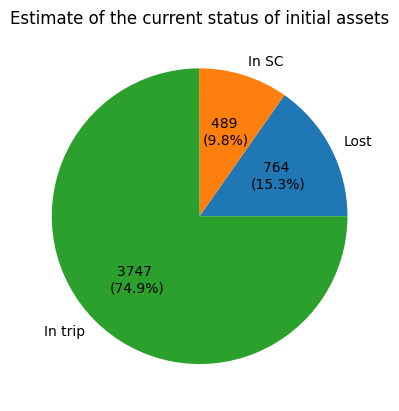

In [30]:
labels = 'Lost', 'In SC', 'In trip'
sizes = [764, 489, 3747]

# Custom function to display number and percentage
def autopct_func(pct, all_vals):
    total = sum(all_vals)
    val = int(round(pct * total / 100.0))
    return f'{val} \n({pct:.1f}%)'

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct=lambda pct: autopct_func(pct, sizes))
ax.set_title("Estimate of the current status of initial assets")
